<a href="https://colab.research.google.com/github/Hsuan7/homework/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9Aw9_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_LSTM%E3%80%81Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

In [114]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件

# 輸入股票代號
stock_id = "2330.tw"
# stock_id = "2357.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''今天往前算幾天'''
# 資料結束時間
#end = dt.date.today()
# 抓取半年資料（現在-過去180天）
#start = end - dt.timedelta(days=180)

'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 11, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

df

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW
0,2020-01-02 00:00:00+00:00,306.430206,339.0,339.0,332.5,332.5,31754120
1,2020-01-03 00:00:00+00:00,306.882172,339.5,345.0,335.5,344.0,41811268
2,2020-01-06 00:00:00+00:00,300.102661,332.0,334.5,332.0,333.0,45343057
3,2020-01-07 00:00:00+00:00,297.842926,329.5,333.0,326.5,332.5,50879181
4,2020-01-08 00:00:00+00:00,297.842926,329.5,333.0,325.0,325.0,37567748
...,...,...,...,...,...,...,...
1168,2024-10-25 00:00:00+00:00,1065.000000,1065.0,1070.0,1060.0,1065.0,22009575
1169,2024-10-28 00:00:00+00:00,1050.000000,1050.0,1080.0,1050.0,1075.0,40142324
1170,2024-10-29 00:00:00+00:00,1040.000000,1040.0,1040.0,1020.0,1035.0,45415773


In [115]:
# 將日期欄位轉為datetime格式
df["Date"] = pd.to_datetime(df["Date"])
# 將日期欄位設為索引
df.set_index("Date", inplace=True)
print(df.head())

Price                       Adj Close   Close    High     Low    Open  \
Ticker                        2330.TW 2330.TW 2330.TW 2330.TW 2330.TW   
Date                                                                    
2020-01-02 00:00:00+00:00  306.430206   339.0   339.0   332.5   332.5   
2020-01-03 00:00:00+00:00  306.882172   339.5   345.0   335.5   344.0   
2020-01-06 00:00:00+00:00  300.102661   332.0   334.5   332.0   333.0   
2020-01-07 00:00:00+00:00  297.842926   329.5   333.0   326.5   332.5   
2020-01-08 00:00:00+00:00  297.842926   329.5   333.0   325.0   325.0   

Price                        Volume  
Ticker                      2330.TW  
Date                                 
2020-01-02 00:00:00+00:00  31754120  
2020-01-03 00:00:00+00:00  41811268  
2020-01-06 00:00:00+00:00  45343057  
2020-01-07 00:00:00+00:00  50879181  
2020-01-08 00:00:00+00:00  37567748  


In [116]:
!pip install tensorflow

In [117]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

def create_dataset(dataset, window_size):
    """
    建立時間序列數據集
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)

def build_lstm_model(window_size):
    """
    建立LSTM模型
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(window_size, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def prepare_and_train_model(stock_data, window_size=10, epochs=20, batch_size=32):
    """
    準備數據並訓練模型
    """
    # 取得收盤價
    close_prices = stock_data[['Close']]

    # 資料集拆分 (80% 訓練, 20% 測試)
    train_size = int(len(close_prices) * 0.8)
    train_data = close_prices[:train_size]
    test_data = close_prices[train_size:]

    print('訓練集形狀：', train_data.shape)
    print('測試集形狀：', test_data.shape)

    # 數據正規化
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # 建立訓練和測試數據集
    X_train, y_train = create_dataset(train_data_scaled, window_size)
    X_test, y_test = create_dataset(test_data_scaled, window_size)

    # 重塑數據為 LSTM 的輸入格式 (samples, time steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # 建立和訓練模型
    model = build_lstm_model(window_size)
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )

    # 評估模型
    mse = model.evaluate(X_test, y_test)
    print(f'測試集 MSE: {mse}')

    # 預測
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # 將預測結果轉為DataFrame
    test_predict = pd.DataFrame(
        y_pred,
        columns=['Predicted'],
        index=test_data[window_size:].index
    )

    # 繪製結果
    plt.figure(figsize=(14, 5))
    plt.plot(close_prices[:train_size + window_size],
             label='Training Data')
    plt.plot(close_prices[train_size + window_size:],
             label='Testing Data',
             color='green')
    plt.plot(test_predict,
             label='Predicted Data',
             color='red')
    plt.title('LSTM Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'model': model,
        'history': history,
        'test_predict': test_predict,
        'mse': mse,
        'scaler': scaler
    }



訓練集形狀： (938, 1)
測試集形狀： (235, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.3153 - val_loss: 0.0324
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0293 - val_loss: 0.0018
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0135 - val_loss: 0.0019
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093 - val_loss: 0.0034
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0091 - val_loss: 0.0026
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0077 - val_loss: 0.0013
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0077 - val_loss: 0.0016
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0078 - val_loss: 0.0013
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.

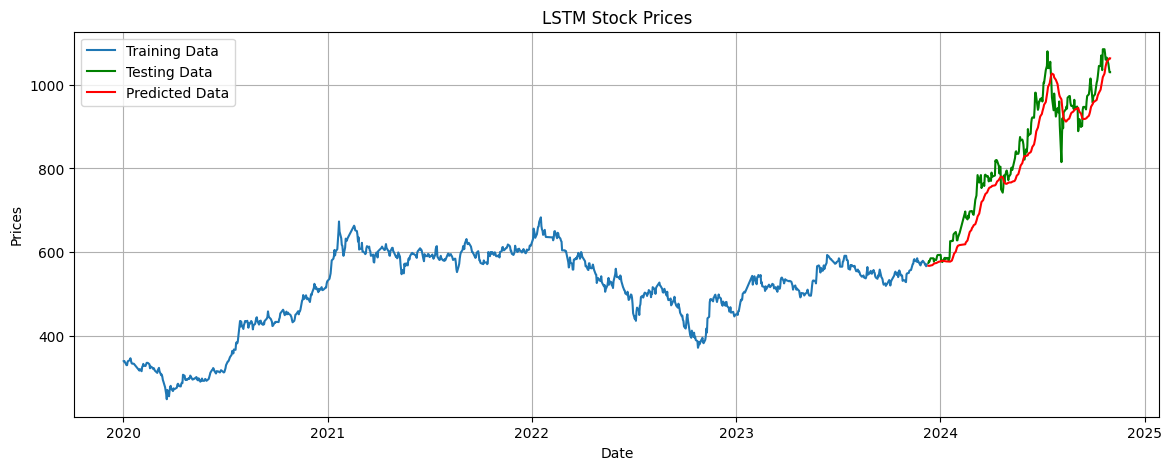

測試集MSE: 0.010673715732991695


In [118]:
# 訓練模型
results = prepare_and_train_model(
    df,
    window_size=20,    # 使用20天預測下一天
    epochs=20,         # 訓練50輪
    batch_size=32      # 批次大小為32
)

# 可以獲取預測結果
predictions = results['test_predict']

# 查看模型表現
print(f"測試集MSE: {results['mse']}")


作業2：
使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

In [119]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf

def create_dataset(dataset, window_size):
    """
    建立時間序列數據集
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

def build_transfromer(window_size, n_features, head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')
    x = inputs

    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout
        )

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs, name='Transformer_Model')

def prepare_and_train_model(stock_data, window_size, epochs, batch_size):
    close_prices = stock_data[['Close']]

    train_size = int(len(close_prices) * 0.8)
    train_data = close_prices[:train_size]
    test_data = close_prices[train_size:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = create_dataset(train_data_scaled, window_size)
    X_test, y_test = create_dataset(test_data_scaled, window_size)

    # 重塑數據為 Transformer 的輸入格式 (samples, time steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # 建立 Transformer 模型
    model = build_transfromer(
        window_size=window_size,
        n_features=1,
        head_size=128,
        num_heads=4,
        ff_dim=2,
        num_trans_blocks=3,
        mlp_units=[64, 32],
        dropout=0.1,
        mlp_dropout=0.1
    )


    model.compile(optimizer='adam', loss='mse')

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )

    mse = model.evaluate(X_test, y_test)
    print(f'測試集 MSE: {mse}')

    # 預測
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # 將預測結果轉為 DataFrame
    test_predict = pd.DataFrame(
        y_pred,
        columns=['Predicted'],
        index=close_prices[train_size + window_size:].index
    )

    # 繪製結果
    plt.figure(figsize=(14, 5))
    plt.plot(close_prices[:train_size + window_size], label='Training Data')
    plt.plot(close_prices[train_size + window_size:], label='Testing Data', color='green')
    plt.plot(test_predict, label='Predicted Data', color='red')
    plt.title('Transformer Stock Prices Prediction')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'model': model,
        'history': history,
        'test_predict': test_predict,
        'mse': mse,
        'scaler': scaler
    }




Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.1581 - val_loss: 0.0194
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0384 - val_loss: 0.0072
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0269 - val_loss: 0.0080
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0146 - val_loss: 0.0011
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0093 - val_loss: 8.4263e-04
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0077 - val_loss: 9.2222e-04
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0062 - val_loss: 8.4279e-04
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0074 - val_loss: 9.3418e-04
Epoch 10/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0062 - val_loss: 8.8778e-04
Epoch 11/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0063 - val_loss: 8.4199e-04
Epoch 12/25
24/24 ━━━━━━━━━━━━━━━━━━━━

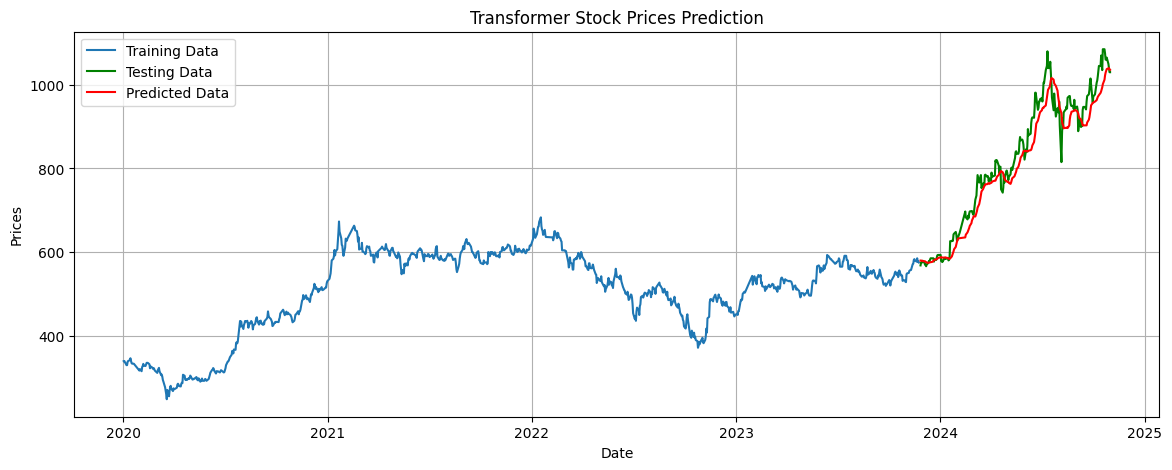

測試集 MSE: 0.007916184142231941


In [121]:
# 訓練模型
results = prepare_and_train_model(
    df,
    window_size=10,
    epochs=25,
    batch_size=32
)

predictions = results['test_predict']
print(f"測試集 MSE: {results['mse']}")